## Banknote classification with fcNN without hidden layer compared to fcNN with hidden layer

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/02_fcnn_with_banknote_keras_torch.ipynb)


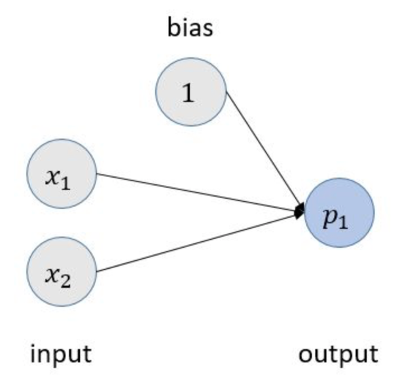

In this notebook you will do your first classification. You will see that fully connected networks without a hidden layer can only learn linar decision boundaries, while fully connected networks with hidden layers are able to learn non-linear decision boundaries.

**Dataset:** You work with a banknote data set and classification task. We have 5 features of wavelet transformed images of banknotes:
>1. variance  (continuous feature)
>2. skewness (continuous feature)
>3. curtosis (continuous feature)
>4. entropy (continuous feature)
>5. class (binary indicating if the banknote is real or fake)  

Don't worry too much about where these features come from.

For this analysis we only use 2 features.

>x1: skewness of wavelet transformed image  
>x2: entropy of wavelet transformed image


**The goal is to classify each banknote to either "real" (Y=0) or "fake" (Y=1).**


**Content:**
* visualize the data in a simple scatter plot and color the points by the class label
* use the Keras library to build a fcNN without hidden layers (logistic regression). Use SGD with the objective to minimize the crossentropy loss.
* visualize the learned decision boundary in a 2D plot
* use the Keras library to build a fcNN with a single hidden layer. Use SGD with the objective to minimize the crossentropy loss.
* visualize the learned decision boundary in a 2D plot
* compare the performace and the decision boundaries of the two models
* stack more hidden layers to the model and playaround with the epochs






#### Imports

In the next two cells, we load all the required libraries and functions from keras and numpy. We also download the data with the 5 featues from the provided url.

In [1]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch # not needed yet

print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Keras_version: 3.6.0
torch_version: 2.1.2
keras backend: torch


In [2]:
# Load data from url
from urllib.request import urlopen
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
raw_data = urlopen(url)
dataset = np.loadtxt(raw_data, delimiter=",")
print(dataset.shape)

(1372, 5)


Let's extract the two featues *x1: skewness of wavelet transformed image* and *x2: entropy of wavelet transformed image*. We print the shape and see that for X  we have 1372 oberservations with two featues and for Y there are 1372 binary labels.

In [3]:
# Here we extract the two features and the labels of the dataset
X=dataset[:,[1,3]]
Y=dataset[:,4]
print(X.shape)
print(Y.shape)

(1372, 2)
(1372,)


Since the banknotes are described by only 2 features, we can easily visualize the positions of real and fake banknotes in a 2D feature space. You can see that the boundary between the two classes is not separable by a straight line. A curved boundary line will do better. But even then we cannot expect a perfect seperation.


number of fakes: 610
number of reals: 762


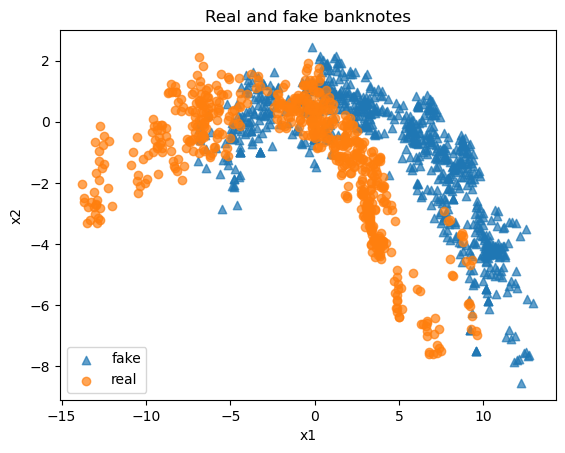

In [4]:
# visualize the data in a 2D feature space.
idx_f = [np.where(Y==1)]
idx_r = [np.where(Y==0)]

print(f'number of fakes: {idx_f[0][0].shape[0]}')
print(f'number of reals: {idx_r[0][0].shape[0]}')

plt.scatter(X[idx_r,0],X[idx_r,1], alpha=0.7,marker='^')
plt.scatter(X[idx_f,0],X[idx_f,1], alpha=0.7,marker='o')
plt.title("Real and fake banknotes")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(("fake","real"),
           loc='lower left',
           fontsize=10)
plt.show()

## 🔧 Calculate the probability that a banknote is fake

The banknote is described by two features $x_1=1$ and $x_2=2.2$ and the weights of the trained NN are $w_1=0.3$ and $w_2=0.2$ and the bias is $b=1$. Use the following python function to calculate the probability that the banknote is fake.


In [7]:
def predict_prob(x1, x2, w1, w2, b):
    return 1/(1+np.exp(-(w1*x1 + w2*x2 + b)))

In [10]:
# @title 🔑 Solution Code { display-mode: "form" }

# solution
predict_prob(x1=1, x2=2.3, w1=0.3, w2=0.2, b=1)

0.8532096601986177

### Computation of the gradient w.r.t. to $w_1$

In deep learning frame works can be calculated automatically via backpropagation (chain rule). 

In [23]:
import torch

# Define the function
def predict_prob(x1, x2, w1, w2, b):
    return 1 / (1 + torch.exp(-(w1 * x1 + w2 * x2 + b)))

# Define inputs with requires_grad=True for w1
x1 = torch.tensor(1.0)
x2 = torch.tensor(2.3)
w1 = torch.tensor(0.3, requires_grad=True)
w2 = torch.tensor(0.2)
b = torch.tensor(1)

# Compute the probability
prob = predict_prob(x1, x2, w1, w2, b)

# Compute the derivative with respect to w1 via backpropagation
prob.backward()

# Print the results
print(f'Predicted probability: {prob.item()}')
print(f'd(prob)/d(w1): {w1.grad.item()}')

Predicted probability: 0.8532096743583679
d(prob)/d(w1): 0.1252429336309433


Calculation by hand using the chain rule:

$$
\frac{\partial \sigma(z)}{\partial w_1} = 
\frac{\partial \sigma(z)}{\partial z}  \cdot \frac{\partial z}{\partial w_1} 
,  \;\;\text{with} \frac{\partial \sigma(z)}{\partial z} = \sigma(z) \cdot (1-\sigma(z))
$$

In [25]:
x1=1.
x2=2.3
w1=0.3
w2=0.2
b=1.

def sig(x):
    return 1/(1+np.exp(-x))

z = w1*x1 + w2*x2 + b
sig(z) * (1 - sig(z)) * x1

0.12524293594237704

### fcNN with only one neuron
Let’s try to use a single neuron with a sigmoid activation function (also known as logistic regression) as classification model to seperate the banknotes.  
We use the sequential API from keras to build the model. To fit the 3 parameters we use the stochastic gradient descent optimizer with a learning rate of 0.15.

#### Definition of a NN with only one neuron after the input


In [5]:
model = Sequential() # starts the definition of the network
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))  # adds a new layer to the network with a single neuron
                                                            # The input is a tensor of size (batch_size, 2), since we don’t specify the Batch Size now, we use None as a placeholder

sgd = SGD(learning_rate=0.15)

# Compile the model
model.compile(loss='binary_crossentropy', # compile model, which ends the definition of the model
              optimizer=sgd,              # using the stochastic gradient descent optimizer
              metrics=['accuracy'])

/Users/oli/Documents/GitHub/dlwbl_eth25/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# summarize the architecture of the NN along with the number of weights
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In the next cell, we train the network. In other words, we tune the parameters that were initialized randomly with stochastic gradient descent to minimize our loss function (the binary crossentropy). We set the batchsize to 128 per updatestep and train for 400 epochs.

In [9]:
# Training of the network
history = model.fit(X, Y,                           # training of the model using the training data stored in X and Y for 4100 epochs
          epochs=100,                               # for 400 epochs
          batch_size=128,                           # fix the batch size to 128 examples
          verbose=0)

Let's look at the so called leraning curve, we plot the accuracy and the loss vs the epochs. You can see that after 100 epochs, we predict around 70% of our data correct and have a loss around 0.51 (these values can vary from run to run).

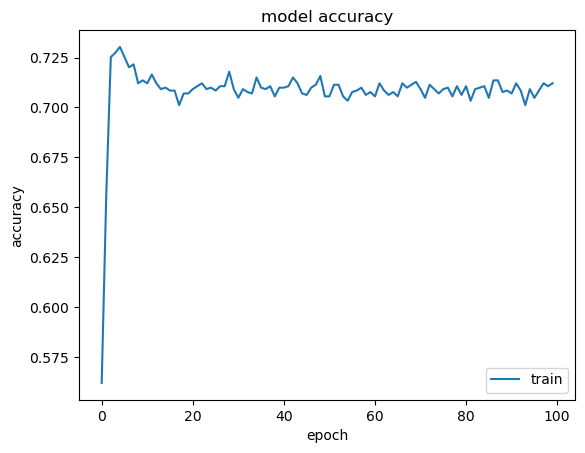

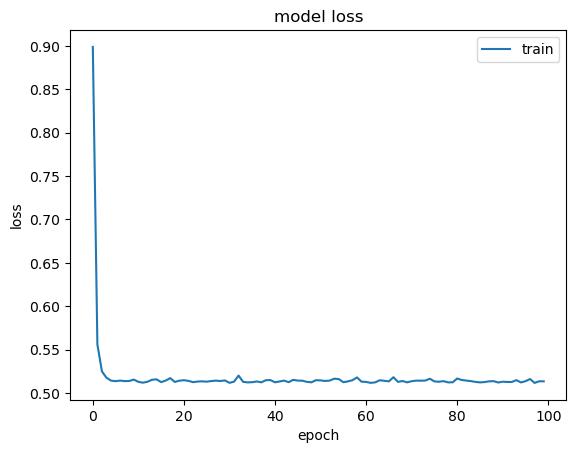

In [10]:
# plot the development of the accuracy and the loss during the training
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

### Plotting the learned decision boundary
Let's visualize which decision boundary was learned by the fcNN with only one output neuron (and no hidden layer).  
As you can see the decision boundary is a straight line. This is not a coincidence but a general property of a single artificial neuron with a sigmoid as activation function and no hidden layer, also known as logistic regression.


(225, 1, 1)


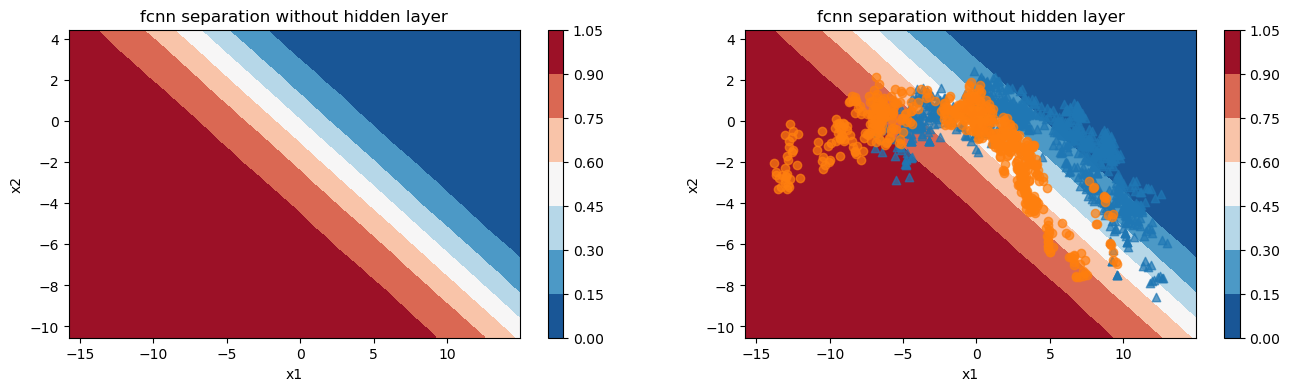

In [15]:
def plotModel(X,Y, model, t):
    # define a grid for the 2D feature space
    # predict at each grid point the probability for class 1

    x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 15) # Define 100 points on the x-axis
    x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 15) # Define 100 points on the x-axis
    X1_grid, X2_grid = np.meshgrid(x1list, x2list)

    # model.predict for respective value x1 and x2
    p = np.array([model.predict(np.reshape(np.array([l1,l2]),(1,2)), verbose=0) for l1,l2 in zip(np.ravel(X1_grid), np.ravel(X2_grid))])
    print(p.shape)
    if len(p.shape) == 3 and p.shape[2]==2:
        p = p[:,:,1] # pick p for class 1 if there are more than 2 classes
    p = np.reshape(p,X1_grid.shape)

    # visualize the predicted probabilities in the 2D feature space
    # once without and once with the data points used for fitting
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,(1))
    cp = plt.contourf(X1_grid, X2_grid, p,cmap='RdBu_r')
    plt.colorbar(cp)
    plt.title(t)
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.subplot(1,2,(2))
    cp = plt.contourf(X1_grid, X2_grid, p,cmap='RdBu_r')
    plt.colorbar(cp)
    idx_f = [np.where(Y==1)]
    idx_r = [np.where(Y==0)]
    plt.scatter(X[idx_r,0],X[idx_r,1], alpha=0.7,marker='^')
    plt.scatter(X[idx_f,0],X[idx_f,1], alpha=0.7,marker='o')
    plt.title(t)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

plotModel(X, Y, model, 'fcnn separation without hidden layer')

### fcNN with one hidden layer

We know that the boundary between the two classes is not descriped very good by a line. Therefore a single neuron is not appropriate to model the probability for a fake banknote based on its two features. To get a more flexible model, we introduce an additional layer between input layer and output layer. This is called hidden layer. Here we use a hidden layer with 8 neurons. We also change the ouputnodes form 1 to 2, to get two ouputs for the probability of real and fake banknote. Because we now have 2 outputs, we use the *softmax* activation function in the output layer. The softmax activation ensures that the output can be interpreted as a probability (see book for details)

#### Definition of the network with two hidden layers                                                                                                                     

In [16]:
# Definition of the network
model = Sequential()
model.add(Dense(8, input_shape=(2,),activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

sgd = keras.optimizers.SGD(learning_rate = 0.15)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

/Users/oli/Documents/GitHub/dlwbl_eth25/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In this is output summary we see that we now have a lot more trainable paramters then before.  
24 = inputdim · outpuntdim + outputbias= 2 · 8 + 8   
18 = inputdim · outpuntdim + outputbias= 8 · 2 + 2   

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42 (168.00 B)

 Trainable params: 42 (168.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
from keras.utils import to_categorical
# Transforms Y=0 to (1,0) and Y=1 to (0,1)
Y_c=to_categorical(Y,2)
Y[0:5], Y_c[0:5]

(array([0., 0., 0., 0., 0.]),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

In the next cell, train the network. In other words, we tune the parameters that were initialized randomly with stochastic gradient descent to minimize our loss function (the categorical crossentropy). We set the batchsize to 128 per updatestep and train for 400 epochs.

In [19]:
# Training of the network
history = model.fit(X, Y_c,
          epochs=400,
          batch_size=128,
          verbose=0)

Epoch 1/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5250 - loss: 0.9033
Epoch 2/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6575 - loss: 0.5783
Epoch 3/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7132 - loss: 0.5551
Epoch 4/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7048 - loss: 0.5387
Epoch 5/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7141 - loss: 0.5345
Epoch 6/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7200 - loss: 0.5297
Epoch 7/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7204 - loss: 0.5248
Epoch 8/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7208 - loss: 0.5236
Epoch 9/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7174 - loss: 0.5199
Epoch 10/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7261 - loss: 0.5015
Epoch 11/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7335 - loss: 0.5064
Epoch 12/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

Let's look again at the learning curve, we plot the accuracy and the loss vs the epochs. You can see that after 100 epochs, we predict around 86% of our data correct and have a loss around 0.29 (thiese values can vary from run to run). This is already alot better than the model without a hidden layer.

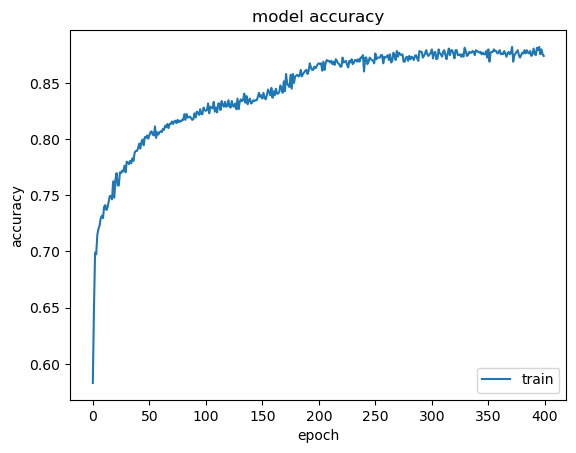

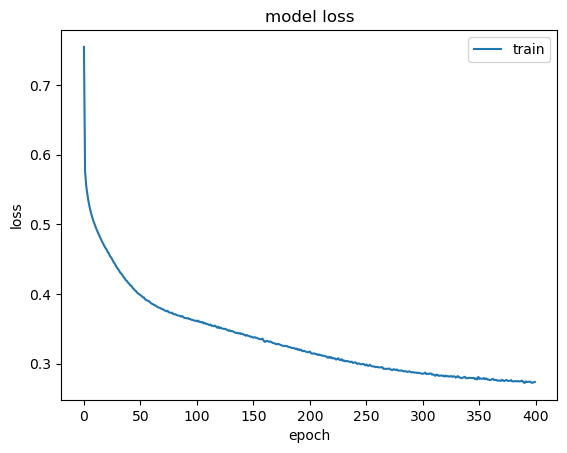

In [20]:
# plot the development of the accuracy and loss during the training
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()


### Plotting the learned decision boundary
Let's visualize which decision boundary was learned by the fcNN with the hidden layer
As you can see the decision boundary is a now curved and not straight anymore. The model (with the hidden layer in the middle) separates the the two classes in the training data better and is able to learn non-linear decision boundaries.



(225, 1, 2)


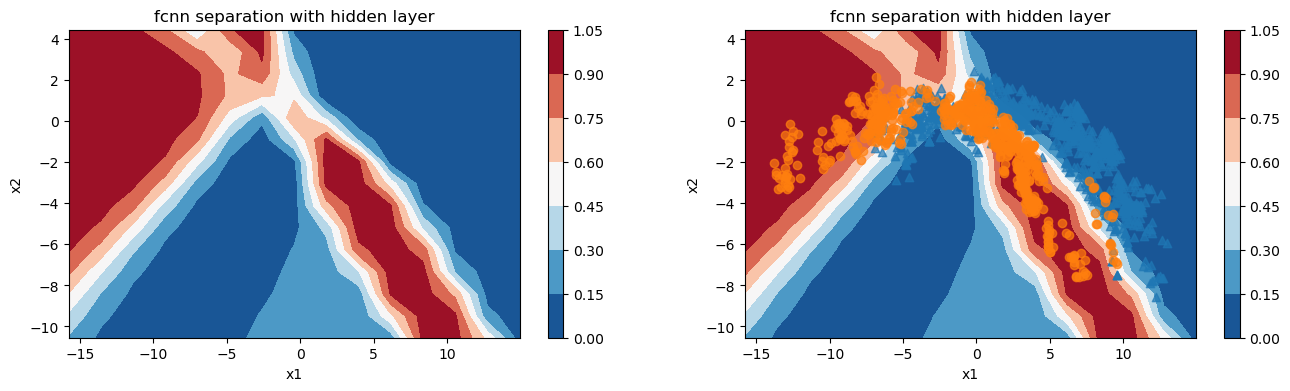

In [21]:
plotModel(X,Y,model, 'fcnn separation with hidden layer')

### 🔧 **YOUR TASK:**

- Add more hidden layers and play around with the training epochs
- What do you observe? Look at the learned decision boundary. How does the loss and the accuracy change?



In [ ]:
## YOUR CODE HERE ##

### 🔑 **Solution:**

<details>
  <summary>🔑 Click here to View Answers:</summary>



- Accuracy increases a bit to ~ 0.91 , the loss (NLL) is around 0.20  with this model
- faster convergence
- Decision boundries do not vary that much

</details>


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5584 - loss: 0.6909
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7370 - loss: 0.5870
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7525 - loss: 0.4984
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7672 - loss: 0.4432
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7625 - loss: 0.4254
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7958 - loss: 0.3844
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8093 - loss: 0.3646
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8152 - loss: 0.3529
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8282 - loss: 0.3392
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8319 - loss: 0.3438
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8543 - loss: 0.3185
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy

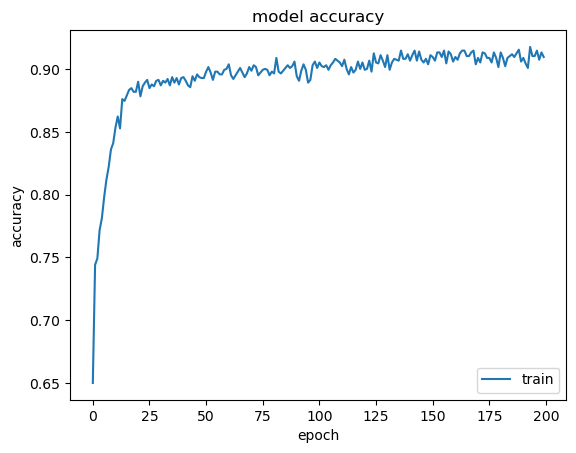

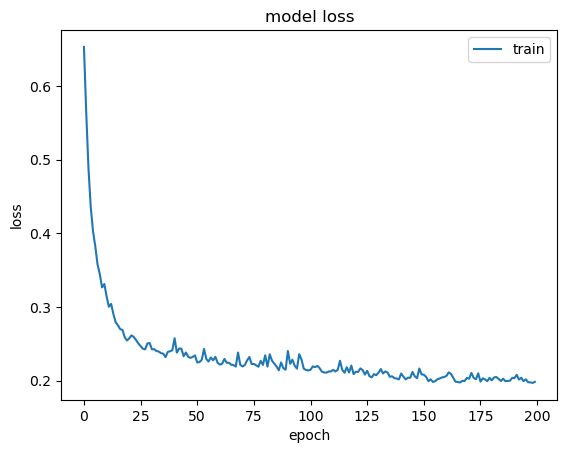

(225, 1, 2)


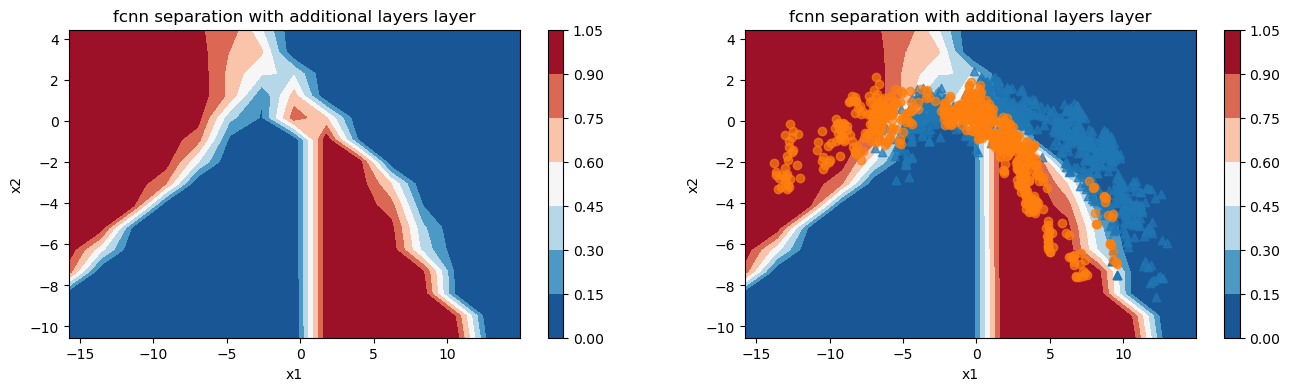

In [22]:
# @title Possible Network { display-mode: "form" }

# Definition of the network
model = Sequential()
model.add(Dense(128, input_shape=( 2,),activation='relu'))  # use different activation functions..
model.add(Dense(64, input_shape=(2,),activation='relu'))   #
model.add(Dense(32, input_shape=( 2,),activation='relu'))
model.add(Dense(16, input_shape=(2,),activation='relu'))
model.add(Dense(8, input_shape=( 2,),activation='relu'))

model.add(Dense(2, activation='softmax')) # Softmax gets the probability for each class

# compile to graph
model.compile(loss='categorical_crossentropy',
              optimizer='adam',                  # Adam optimizer
              metrics=['accuracy'])

# Training of the network
history = model.fit(X, Y_c,
          epochs=200,
          batch_size=128,
          verbose=1)

# plot the development of the accuracy and loss during the training
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()


plotModel(X,Y,model, 'fcnn separation with additional layers layer')
